## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import random as rd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

#from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
#from analysis_utils.Analysis import print_accuracy_and_classification_report, predict_classes, get_somatic_error_type

In [2]:
from scipy.stats import pearsonr
import matplotlib.ticker as ticker
from itertools import cycle

sns.set_style('white')


def _calculate_hist(probabilities,
                    bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]):
    '''Calculates the counts and mean of each bin for a histogram using \
    defined bin intervals.

    Parameters:
        probabilities (numpy.array): Array of probabilites
        bins (list): Defined bins to calculate. Default [0,.1,.2,.3,.4,
                     .5,.6,.7,.8,.9,1]
    Returns:
        (counts, means): Lists of the counts and means of each bin
    '''
    counts = list()
    means = list()
    for i in range(0, len(bins) - 1):
        count = len(probabilities[(probabilities > bins[i])
                                  & (probabilities <= bins[i + 1])])
        if count == 0:
            counts.append(0)
            bin_mean = np.mean([bins[i], bins[i+1]])
            means.append(bin_mean)
        else:
            counts.append(count)
            means.append(np.mean(probabilities[(probabilities > bins[i]) &
                                               (probabilities <= bins[i + 1])])
                         )
    return np.array(counts), np.array(means)

def create_roc_curve(Y, probabilities, class_lookup, title, ax):
    '''Create ROC curve to compare multiclass model performance.

    Parameters:
        Y (numpy.array): Truth labels
        probabilities (numpy.array): Output of model for each class
        class_lookup (dict): lookup hash of truth labels
        title (str): Plot title
    '''
    n_classes = Y.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    ax.set_title(title)
    if n_classes == 3:
        colors = cycle(['orange', 'red', 'black'])
    else:
        colors = cycle(['orange', 'red', 'aqua', 'black'])
    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        ax.plot(fpr[i], tpr[i], color=color,
                label='ROC curve of class {0} (area = {1:0.2f})'.format(
                    class_lookup[i], roc_auc[i]))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    # plt.show()


def create_feature_importance_plot(feature_importance_metrics, title):
    '''Create bar plot illustrating importance of each feature.

    Parameters:
        feature_importance_metrics (pandas.DataFrame): DataFrame with features
                                                       on index and a column
                                                       named delta_auc
                                                       containing the change
                                                       in roc auc values
        title (str): Title of plot
    '''
    feature_importance_metrics.replace(
        {'feature': {'var': 'variant', 'ref': 'reference',
                     'avg': 'average',
                     '_se_': '_single_end_',
                     '3p': '3_prime', '_': ' '}},
        regex=True, inplace=True)
    sns.barplot(y='feature', x='delta_auc',
                data=feature_importance_metrics.head(30),
                color='cornflowerblue')
    plt.xlabel('Delta average AUC')
    plt.ylabel('Feature')
    plt.title(title)


def make_model_output_plot(probabilities, title):
    """Make plot that show the distribution of model output

        Parameters:
            probabilities (numpy.array): array of model output with samples
                                         on row and classes in columns
            title (str): Plot title
    """
    ax = sns.distplot(probabilities[:, 0:1])
    sns.distplot(probabilities[:, 1:2], ax=ax)
    sns.distplot(probabilities[:, 2:3], ax=ax)
    ax.legend(['Ambiguous', 'Fail', 'Somatic'])
    ax.set_xlabel('Model output')
    ax.set_ylabel('Density')
    ax.set_title(title)


In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import preprocessing

def get_roc_auc(probabilities, Y):
    # for binary classifier add labels for fail category
    if len(Y.shape) == 1:
        Y = np.array([np.logical_not(Y), Y]).T
    n_classes = Y.shape[1]
    fpr = [0] * n_classes
    tpr = [0] * n_classes
    roc_auc = [0] * n_classes
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    return np.mean(roc_auc)


def print_accuracy_and_classification_report(labels, prediction):
    """Print model accuracy and classification report.

    Args:
        labels (numpy.array): Truth lables
        prediction (numpy.array): Model predictions
    """
    print('Cross validation accuracy:')
    print('\t', metrics.accuracy_score(labels, prediction))
    print('\nCross validation classification report\n')
    print(metrics.classification_report(labels, prediction))


def predict_classes(probabilities):
    """Predict class labels from probabilities

    Args:
        probabilities (numpy.array): model output for each class
    Returns:
        (numpy.array): Model predicted class labels
    """
    predicted = np.array(
        [list(a).index(max(list(a))) for a in list(probabilities)])
    label_binarizer = preprocessing.LabelBinarizer()

    label_binarizer.fit(range(max(predicted) + 1))
    return label_binarizer.transform(predicted)


## Read the data

In [4]:
df=pd.read_excel('Data.xlsx')

In [5]:
df.head()

,Column1,3-Breast-Her2-ampl,8-Breast-WT,10-Breast-Her2-ampl,Breast-100,15-Breast-Her2-ampl,16-Breast-WT,21-Breast-WT,33-Breast-Her2-ampl,42-Breast-Her2-ampl,...,MGH-NSCLC-L20-TR500,MGH-NSCLC-L22-TR462,MGH-NSCLC-L23-TR524,MGH-NSCLC-L25-TR480,MGH-NSCLC-L39-TR519,MGH-NSCLC-L40-TR520,MGH-NSCLC-L51-TR521,MGH-NSCLC-L58-TR525,MGH-NSCLC-L59-TR522,MGH-NSCLC-L65-TR523
0,ENSG00000000003,0,0,0,0,17,0,0,0,0,...,0,5,10,9,0,0,0,0,0,0
1,ENSG00000000005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000000419,44,14,16,8,9,0,139,108,55,...,2,41,40,15,1,0,13,0,0,10
3,ENSG00000000457,26,1,14,0,4,20,1,26,24,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000000460,81,98,18,17,0,20,144,26,97,...,23,1,6,22,30,0,1,50,6,2


In [6]:
df_T = df.transpose()

In [7]:
new_header = df_T.iloc[0] #grab the first row for the header
df_T = df_T[1:] #take the data less the header row
df_T.columns = new_header #set the header row as the df header

In [8]:
df_T.shape

(285, 57736)

In [9]:
df_T['target']='c'

In [10]:
x=df_T.index

In [14]:
i=0
for y in x:
    if (y.find('HD') != -1):
        df_T['target'].iloc[i]='h'
  #elif (y.find('Control') != -1):
   # df['target'].iloc[i]=1
        i=i+1

In [15]:
df_T.target.value_counts()

c    240
h     45
Name: target, dtype: int64

In [16]:
Processed_data=df_T

In [17]:
#df.replace(0, np.nan, inplace=True)

In [18]:
#df=df.dropna(axis='columns', thresh=284) #drop all columns having 250 NA's
#df.shape

## Cancerous or Healthy

In [19]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [20]:
Processed_data.groupby('target').size()

target
c    240
h     45
dtype: int64

In [21]:
# Get labels for training data
Y = Processed_data.target.values
# Get training data 
X = Processed_data.drop(['target'], axis=1)

In [22]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [23]:
# Determine shape of training data features for cross-validation
X_train.shape

(190, 57736)

In [24]:
# Determine shape of training data target for cross-validation
Y_train.shape

(190,)

In [25]:
# Set parameters for the Random Forest Model
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)

In [26]:
# Perform cross validation and pull AUC for various splits
# auc = []
# for n in [100, 1000, 2000]:
#     est = RandomForestClassifier(n_estimators=n, max_features=8,n_jobs=-1, 
#                                  oob_score=True)
#     probs = cross_val_predict(est, X_train, Y_train, cv=kfold, method='predict_proba')
#     temp_auc = []
#     for j in range(Y_one_hot.shape[1]):
#         temp_auc.append(metrics.roc_auc_score(Y_one_hot[:, j], probs[:, j]))
#     auc.append(temp_auc)
#     print('Test AUC for {0} trees: '.format(n), temp_auc)
#     print('--------------------------------------------------')

Test AUC for 100 trees:  [0.642057517853696, 0.6420575178536962]
--------------------------------------------------
Test AUC for 1000 trees:  [0.6804670912951168, 0.6804670912951167]
--------------------------------------------------
Test AUC for 2000 trees:  [0.6850028951939781, 0.6850028951939781]
--------------------------------------------------


In [29]:
# Set parameters for the estimator
estimator = RandomForestClassifier(n_estimators=2000, max_features=8, 
                                   n_jobs=-1, oob_score=True)

In [36]:
# Perform cross validation
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

In [37]:
# Save the probabilities in /data folder
#np.save('../data/random_forest/1000estimators.npy', probabilities)

In [65]:
# print accuracy report
# print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

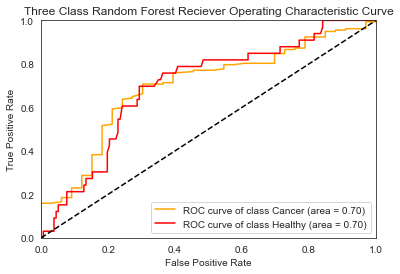

In [39]:
# Plot ROC for Random Forest Model
class_lookup = {0: 'Cancer', 1: 'Healthy'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Three Class Random'
                 ' Forest Reciever Operating Characteristic Curve', ax)

## Feature Importance Analysis

In [45]:
# Rebuild random forest model
forest = estimator.fit(X_train, Y_train)

In [46]:
def sum_features(feature_import, label):
    starts_with_label = feature_import.feature.str.startswith(label)
    return feature_import.importance[starts_with_label].sum()

In [53]:
 # Create function to determine the feature importance 
def create_feature_importance_plot(forest):
    feature_import = pd.DataFrame([Processed_data.drop(['target'], axis=1).columns.values,forest.feature_importances_]).T
    feature_import.columns = ['feature', 'importance']
    summed_importances = []
#     for label in ['disease', 'reviewer']:
#         summed_importances.append([label, sum_features(feature_import, label)])
#     summed_importances = pd.DataFrame(summed_importances, columns=['feature','importance'])
#     feature_import.to_pickle(save_fp)
#     print(feature_import ['feature'])
#     for i in feature_import ['feature']:
#         print(i)
    feature_import.sort_values('importance', ascending=False, inplace=True)
    sns.barplot(y='feature', x='importance', data=feature_import.head(18), color='darkorange')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Random Forest Feature Importance')

## Test set performance

In [54]:
#Get probabilites for hold out test set
forest = estimator.fit(X_train, Y_train)
test_prob = forest.predict_proba(X_test)

In [55]:
# Add labels
Y_test_labels = enc.fit_transform(Y_test)

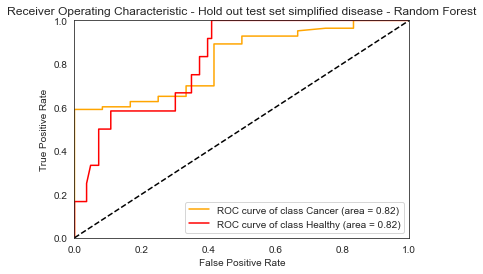

In [56]:
# PLot test set ROC
fig, ax = plt.subplots()
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set simplified disease - '
                 'Random Forest', ax)

## Confusion Matrix

In [63]:
# from sklearn.metrics import plot_confusion_matrix
# from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# conf_mat = confusion_matrix(Y_one_hot, predict_classes(probabilities), normalize='true')
# print(conf_mat)


# disp = plot_confusion_matrix(classifier, X_test, y_test,
# display_labels=class_names, cmap=plt.cm.Blues, normalize='true')

## Multi-Class Setting

In [ ]:
# df['Patient type']=0

In [60]:
# i=0                                           
# for y in x:
#     if (y.find('HD') != -1):
#         df['list'].iloc[i]='Healthy Donor (HD)'
#     #i=i+1
#     elif (y.find('liver') != -1):
#         df['list'].iloc[i]='Hepatobiliary carcinoma (HBC)'
#     #i=i+1
#     elif (y.find('Platelet-hiseq') != -1):
#         df['list'].iloc[i]='HC'
#     elif (y.find('Breast') != -1):
#         df['list'].iloc[i]='Breast carcinoma (BrCa)'
#     #i=i+1
#     elif (y.find('Chol') != -1):
#         df['list'].iloc[i]='Hepatobiliary carcinoma (HBC)'
#     #i=i+1
#     elif (y.find('CRC') != -1):
#         df['list'].iloc[i]='Colorectal cancer (CRC)'
#     #i=i+1
#     elif (y.find('GBM') != -1):
#         df['list'].iloc[i]='Glioblastoma (GBM)'
#     #i=i+1
#     elif (y.find('Pancr') != -1):
#         df['list'].iloc[i]='Pancreatic Adenocarcinoma (PAAD)'
#     #i=i+1
#     elif (y.find('Panc') != -1):
#         df['list'].iloc[i]='Pancreatic Adenocarcinoma (PAAD)'
#     elif (y.find('Lung') != -1):
#         df['list'].iloc[i]='Non-small cell lung cancer (NSCLC)'
#     #i=i+1
#     elif (y.find('BrCa') != -1):
#         df['list'].iloc[i]='Breast carcinoma (BrCa)'
#     #i=i+1
#     elif (y.find('Control') != -1):
#         df['list'].iloc[i]='Healthy Donor (HD)'
#     elif (y.find('NSCLC') != -1):
#         df['list'].iloc[i]='Non-small cell lung cancer (NSCLC)'
#     elif (y.find('Unknown') != -1):
#         df['list'].iloc[i]='Hepatobiliary carcinoma (HBC)'
#     else:
#         df['list'].iloc[i]='Hepatobiliary carcinoma (HBC)'
#     i=i+1

In [ ]:
# df['list'] # non-small cell lung cancer, 
#            #colorectal cancer, 
#            #pancreatic cancer, 
#            #glioblastoma, 
#            #breast cancer and 
#            #hepatobiliary carcinomas
# df.list.value_counts()

## Trying K-means Clustering

In [62]:
# from sklearn.cluster import KMeans
# # defining the kmeans function with initialization as k-means++
# kmeans = KMeans(n_clusters=2, init='k-means++')

# # fitting the k means algorithm on scaled data
# kmeans.fit(df)
# kmeans = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++')
# kmeans.fit(data_scaled)
# pred = kmeans.predict(data_scaled)
# frame = pd.DataFrame(data_scaled)
# frame['cluster'] = pred
# frame['cluster'].value_counts()